### Bollinger Bands

<font color='orange'>
    Bollinger Bands is a type of price envelope, which is normally plotted as two standard deviations, both positively and negatively, away from a simple moving average (SMA) of a security's price and can be adjusted to user preferences. When the price continually touches the upper Bollinger Band, it can indicate an overbought signal, and it can generate oversold signal when touches lower band instead.
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
from datetime import datetime
from collections import namedtuple
import math
from numbers import Real
import jdc
plt.style.use('seaborn')

/var/folders/6b/zsc6z0x51ls8w8wy4m79d0y80000gn/T/ipykernel_11618/913403548.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


> #### Implementation:

In [2]:
class BB:
    '''
    Description: 
        Class for the vectorized backtesting of BB-based trading strategies.

    Properties:
    ===========
    symbol: str
        ticker symbol
    sma: int
        time window in days for SMA
    std_amount: int
        distance for upper/lower bands in std units
    start_date: str or datetime
        start date for data retrieval
    end_date: str or datetime
        end date for data retrieval
    tc: Real
        proportional transaction costs per trade

    Methods:
    ========
    load_data:
        retrieve and prepare data given a file path
    prepare_data:
        prepare data
    run_strategy:
        run the backtest for the BB-based strategy
    run_with_updated_params:
        update BB parameters and rerun strategy
    optimize_params:
        implement a brute force optimization to search for optimal BB parameters
    plot_result:
        plot the performance of the BB strategy compared to buy-and-hold strategy
    '''
    def __init__(self, symbol, sma, std_amount, start_date, end_date, tc):
        if isinstance(symbol, str):
            self._symbol = symbol
        else:
            raise ValueError('Symbol must be a string.')

        if isinstance(sma, int):
            self._sma = sma
        else:
            raise ValueError('Sma must be an integer.')

        if isinstance(std_amount, int):
            self._std_amount = std_amount
        else:
            raise ValueError('Std_amount must be an integer.')

        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')

        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')

        if isinstance(tc, Real):
            self._tc = tc
        else:
            raise ValueError('Trading_cost must be a real number.')

        self.data = None
        self.path = None
        self.result = None
        self.perf = None

    def __repr__(self):
        return f'BBBackTester(symbol: {self.symbol}, sma: {self.sma}, std_amount: {self.std_amount}, start_date: {self.start_date}, end_date: {self.end_date})'
    
    # Symbol
    @property
    def symbol(self):
        return self._symbol
    @symbol.setter
    def symbol(self, symbol):
        if isinstance(symbol, str):
            self._symbol = symbol
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Symbol must be a string.')

    # Sma
    @property
    def sma(self):
        return self._sma
    @sma.setter
    def sma(self, sma):
        if isinstance(sma, int):
            self._sma = sma
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Sma must be an integer.')

    # Std_amount
    @property
    def std_amount(self):
        return self._std_amount
    @std_amount.setter
    def std_amount(self, std_amount):
        if isinstance(std_amount, int):
            self._std_amount = std_amount
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Std_amount must be an integer.')

    # Start_date
    @property
    def start_date(self):
        return self._start_date
    @start_date.setter
    def start_date(self, start_date):
        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    # End_date
    @property
    def end_date(self):
        return self._end_date
    @end_date.setter
    def end_date(self, end_date):
        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    @property
    def tc(self):
        return self._tc
    @tc.setter
    def tc(self, tc):
        if isinstance(tc, Real):
            self._tc = tc
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Trading_cost must be a real number.')

In [3]:
%%add_to BB
def load_data(self, path):
    '''
    Retrieve and prepare the data given a file path.
    '''
    if isinstance(path, str):
        self.path = path
    else:
        raise ValueError('File path of data must be a string.')
    self.prepare_data()

In [4]:
%%add_to BB
def prepare_data(self):
    '''
    Prepare data.
    '''
    # Load data
    self.data = pd.read_csv(self.path, parse_dates=[0], index_col=0)
    # Filter data for given symbol
    self.data = self.data[self.symbol].to_frame().dropna()
    # Filter data for given period
    self.data = self.data.loc[self.start_date : self.end_date]
    self.data.rename(columns={self.symbol: 'Price'}, inplace=True)
    
    # Sma (middle band)
    self.data['SMA'] = self.data['Price'].rolling(self.sma).mean()
    # Upper band
    self.data['Upper'] = self.data['SMA'] + self.std_amount * self.data['Price'].rolling(self.sma).std()
    # Lower band
    self.data['Lower'] = self.data['SMA'] - self.std_amount * self.data['Price'].rolling(self.sma).std()
    
    # Return of buy-and-hold strategy
    return_buy_and_hold = self.data['Price'] / self.data['Price'].shift(1)
    # Return (log) of buy-and-hold strategy
    self.data['Return_Buy_Hold(log)'] = np.log(return_buy_and_hold)
    # Cumulative return of buy-and-hold strategy
    self.data['Return_Buy_Hold(cum)'] = self.data['Return_Buy_Hold(log)'].cumsum().apply(np.exp)

In [5]:
%%add_to BB
def run_strategy(self):
    '''
    Backtest the BB strategy.
    '''
    data = self.data.copy().dropna()
    data['Distance'] = data['Price'] - data['SMA']
    # If price crosses below lower band, long the asset
    data['Position'] = np.where(data['Price'] < data['Lower'], 1, np.nan)
    # If price crosses upper band, short the asset
    data['Position'] = np.where(data['Price'] > data['Upper'], -1, data['Position'])
    # If price crosses middle band (SMA), take neutral position
    data['Position'] = np.where(data['Distance'] * data['Distance'].shift(1) < 0, 0, data['Position'])
    # Forward fill the position (using previous position to fill nans), and fill the rest nans (the initial ones with no positions) with 0
    data['Position'] = data['Position'].ffill().fillna(0)
    # Number of trades
    data['Trades'] = data['Position'].diff().fillna(0).abs()
    
    # Return of bb strategy (position of previous day * return of current day)
    data['Return_BB(log)'] = data['Position'].shift(1) * data['Return_Buy_Hold(log)']
    data.dropna(inplace=True)
    # Return of bb strategy (excluding trading cost)
    data['Return_BB_Net(log)'] = data['Return_BB(log)'] - data['Trades'] * self.tc

    # Cumulative return of bb strategy
    data['Return_BB(cum)'] = data['Return_BB(log)'].cumsum().apply(np.exp)
    # Cumulative return of bb strategy (excluding trading cost)
    data['Return_BB_Net(cum)'] = data['Return_BB_Net(log)'].cumsum().apply(np.exp)
    self.result = data

    abs_perf = self.result['Return_BB(cum)'].iloc[-1]
    out_perf = abs_perf - data['Return_Buy_Hold(cum)'].iloc[-1]

    self.perf = namedtuple('bb_performance', ['bb_abs_performance', 'bb_out_performance'])
    self.perf.bb_abs_performance = round(abs_perf, 6)
    self.perf.bb_out_performance = round(out_perf, 6)
    return self.perf.bb_abs_performance

In [6]:
%%add_to BB
def run_with_updated_params(self, bb):
    '''
    update BB parameters and rerun strategy.

    Parameters:
    ===========
    bb: tuple
        bb parameter tuple
    '''
    self.sma = int(bb[0])
    self.std_amount = int(bb[1])
    return -self.run_strategy()

In [7]:
%%add_to BB
def optimize_params(self, sma_range, std_amount_range):
    '''
    Find optimal BB parameters in terms of best possible BB return.
    
    Parameters:
    ===========
    sma_range, std_amount_range: tuple
        bb ranges tuples      
    '''
    opt = brute(self.run_with_updated_params, ranges=(sma_range, std_amount_range), finish=None)
    return opt

In [8]:
%%add_to BB
def plot_result(self):
    '''
    Plots the cumulative performance of the BB strategy comparing to buy-and-hold.
    '''
    if self.result is None:
        print('No result for display, please run the strategy')
    else:
        title = f'{self.symbol} | BB (Sma = {self.sma}, Std_amount = {self.std_amount}) | TC = {self.tc}'
        self.result[['Return_Buy_Hold(cum)', 'Return_BB(cum)', 'Return_BB_Net(cum)']].plot(title=title, figsize=(12, 8))

> #### Example:

In [9]:
PATH = './data/intraday_pairs.csv'

SMA = 30
STD_AMOUNT = 2
SMA_RANGE = (25, 100, 1)
STD_AMOUNT_RANGE = (1, 5, 1)

SYMBOL1 = 'EURUSD'
SYMBOL2 = 'GBPUSD'
START_DATE = '2018-01-01'
END_DATE = '2019-12-31'
TRADING_COST = 0.00007

In [10]:
bb1 = BB(symbol=SYMBOL1,
         sma=SMA,
         std_amount=STD_AMOUNT,
         start_date=START_DATE, 
         end_date=END_DATE,
         tc=TRADING_COST)
bb1

BBBackTester(symbol: EURUSD, sma: 30, std_amount: 2, start_date: 2018-01-01, end_date: 2019-12-31)

In [11]:
bb1.load_data(path = PATH)
bb1.data.head()

,Price,SMA,Upper,Lower,Return_Buy_Hold(log),Return_Buy_Hold(cum)
time,,,,,,
2018-01-01 22:00:00+00:00,1.201205,NaN,NaN,NaN,NaN,NaN
2018-01-02 04:00:00+00:00,1.207055,NaN,NaN,NaN,0.004858,1.004870
2018-01-02 10:00:00+00:00,1.204440,NaN,NaN,NaN,-0.002169,1.002693
2018-01-02 16:00:00+00:00,1.205800,NaN,NaN,NaN,0.001129,1.003825
2018-01-02 22:00:00+00:00,1.204690,NaN,NaN,NaN,-0.000921,1.002901


In [12]:
bb1.run_strategy()
bb1.result.head()

,Price,SMA,Upper,Lower,Return_Buy_Hold(log),Return_Buy_Hold(cum),Distance,Position,Trades,Return_BB(log),Return_BB_Net(log),Return_BB(cum),Return_BB_Net(cum)
time,,,,,,,,,,,,,
2018-01-11 10:00:00+00:00,1.204915,1.200628,1.210415,1.190841,0.008455,1.003089,0.004287,0.0,0.0,0.000000,0.000000,1.000000,1.000000
2018-01-11 16:00:00+00:00,1.203205,1.200500,1.210035,1.190964,-0.001420,1.001665,0.002705,0.0,0.0,-0.000000,-0.000000,1.000000,1.000000
2018-01-11 22:00:00+00:00,1.205165,1.200524,1.210104,1.190943,0.001628,1.003297,0.004641,0.0,0.0,0.000000,0.000000,1.000000,1.000000
2018-01-12 04:00:00+00:00,1.212530,1.200748,1.211122,1.190374,0.006093,1.009428,0.011782,-1.0,1.0,0.000000,-0.000070,1.000000,0.999930
2018-01-12 10:00:00+00:00,1.214820,1.201086,1.212589,1.189583,0.001887,1.011334,0.013734,-1.0,0.0,-0.001887,-0.001887,0.998115,0.998045


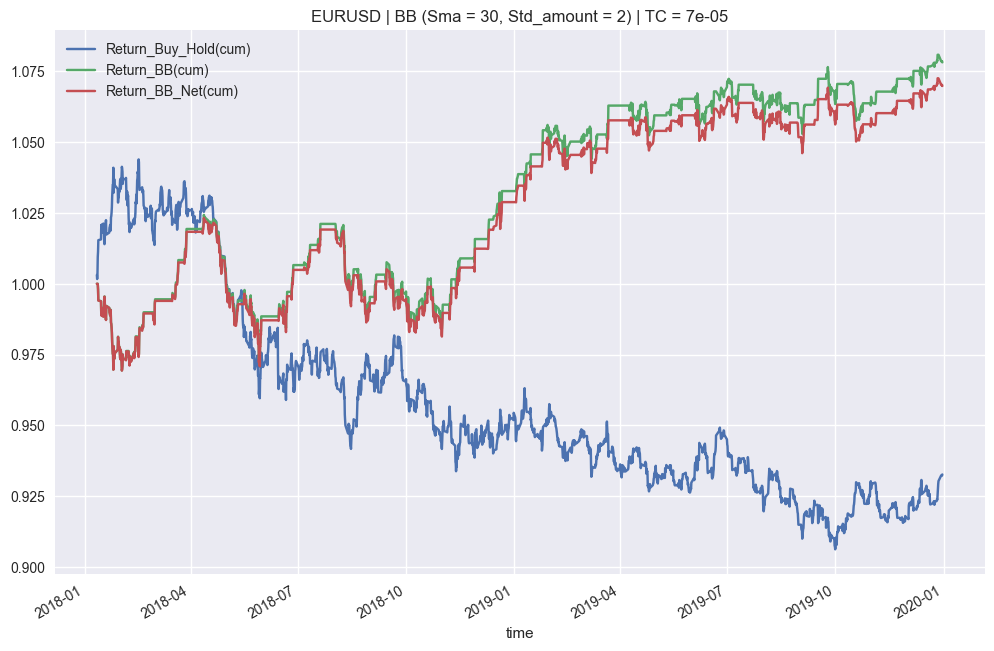

In [13]:
bb1.plot_result()

In [14]:
bb1.optimize_params(sma_range=SMA_RANGE, std_amount_range=STD_AMOUNT_RANGE)

array([58.,  1.])

In [15]:
bb2 = BB(symbol=SYMBOL2,
         sma=SMA,
         std_amount=STD_AMOUNT,
         start_date=START_DATE, 
         end_date=END_DATE,
         tc=TRADING_COST)
bb2

BBBackTester(symbol: GBPUSD, sma: 30, std_amount: 2, start_date: 2018-01-01, end_date: 2019-12-31)

In [16]:
bb2.load_data(path = PATH)
bb2.data.head()

,Price,SMA,Upper,Lower,Return_Buy_Hold(log),Return_Buy_Hold(cum)
time,,,,,,
2018-01-01 22:00:00+00:00,1.351705,NaN,NaN,NaN,NaN,NaN
2018-01-02 04:00:00+00:00,1.354830,NaN,NaN,NaN,0.002309,1.002312
2018-01-02 10:00:00+00:00,1.357860,NaN,NaN,NaN,0.002234,1.004554
2018-01-02 16:00:00+00:00,1.359180,NaN,NaN,NaN,0.000972,1.005530
2018-01-02 22:00:00+00:00,1.359530,NaN,NaN,NaN,0.000257,1.005789


In [17]:
bb2.run_strategy()
bb2.result.head()

,Price,SMA,Upper,Lower,Return_Buy_Hold(log),Return_Buy_Hold(cum),Distance,Position,Trades,Return_BB(log),Return_BB_Net(log),Return_BB(cum),Return_BB_Net(cum)
time,,,,,,,,,,,,,
2018-01-11 10:00:00+00:00,1.353515,1.354482,1.360311,1.348653,0.003516,1.001339,-0.000967,0.0,0.0,0.000000,0.000000,1.000000,1.000000
2018-01-11 16:00:00+00:00,1.353660,1.354443,1.360278,1.348608,0.000107,1.001446,-0.000783,0.0,0.0,0.000000,0.000000,1.000000,1.000000
2018-01-11 22:00:00+00:00,1.354875,1.354343,1.360037,1.348649,0.000897,1.002345,0.000532,0.0,0.0,0.000000,0.000000,1.000000,1.000000
2018-01-12 04:00:00+00:00,1.361205,1.354411,1.360383,1.348438,0.004661,1.007028,0.006794,-1.0,1.0,0.000000,-0.000070,1.000000,0.999930
2018-01-12 10:00:00+00:00,1.368930,1.354724,1.362517,1.346931,0.005659,1.012743,0.014206,-1.0,0.0,-0.005659,-0.005659,0.994357,0.994287


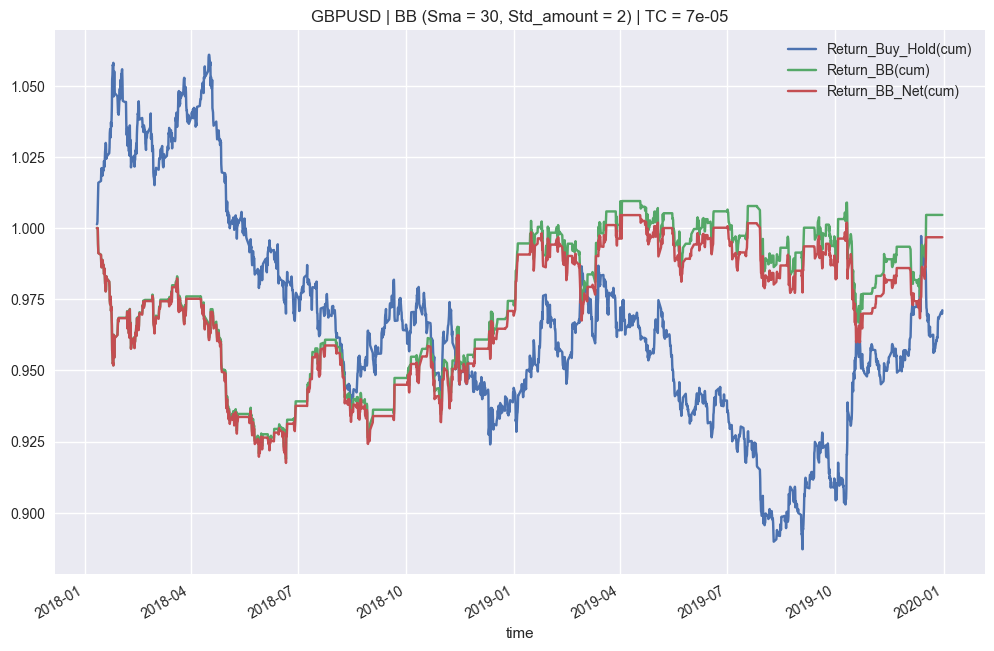

In [18]:
bb2.plot_result()

In [19]:
bb2.optimize_params(sma_range=SMA_RANGE, std_amount_range=STD_AMOUNT_RANGE)

array([79.,  1.])